# Who will survive the Titanic Disaster?

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a ML model capable of predicting whether or not someone would survive the titanic disaster based on various attributes of the people.

We're going to take the following approach:
1. Problem Definition
2. Data
3. Evaluation
4. Features
5. Modeling
6. Experimentation

# 1. Problem Definition

In a statement:
`Given various personal and socio-economic attributes, can we predict if they woudl survive?`


# 2. Data

The original data came from the Kaggle Competition Titanic: Machine Learning from Disaster
https://www.kaggle.com/c/titanic/data

# 3. Evaluation

The goal is to reach roughly 80% accuracy, so we can more often than not determine survival

# 4. Features

 1. survival: Did the person survive?
 2. pclass: What Class of Ticket did the passenger purchase?
 3. sex: Male (0), Female (1)
 4. Age
 5. sibsp: # of siblings / spouses aboard the Titanic	
 6. parch: # of parents / children aboard the Titanic	
 7. ticket	   	
 8. fare
 9. cabin
 10. embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

## Features that (probably) don't matter
1. Name - We already have passenger ID which is all that really matters
2. Ticket - the ticket number that they bought isn't important as there are 681 unique values
3. Cabin - this should already be taken into account basically by Class, plus theres over 600 missing values which doesn't help
4. Embarked - it shouldn't matter where they left from if they died, but i'll add this one back

# Preparing the tools

We're going to use pandas, NumPy, and Matplotlib for data analysis, and we are going to use Sci-KitLearn and XGboost for modeling

In [1]:
# Import all the tools that you need

# Regular EDA (exploratory data analysis) and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

# we want our plots to appear inside the notebook
%matplotlib inline
plt.style.use('seaborn-whitegrid')

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Model from XGBoost
import xgboost as xgb

# Model from catboost
from catboost import CatBoostClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Lets take a good look at our data
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
def clean_dataframe(df=df):
    '''
    This Function drops the less useful information and cleans up the other stuff
    '''
    df.drop(['Name','Ticket','Cabin'], axis = 1, inplace = True)
    
    num_sex, num_embarked = [], []
    
    # Turn Sex into num
    for i in df['Sex']:
        if i =='female':
            num_sex.append(1)
        else:
            num_sex.append(0)
    df['Sex'] = num_sex
    
    # Turn Embarked into Categorical
    for i in df['Embarked']:
        if i == 'C':
            num_embarked.append(1)
        elif i =='Q':
            num_embarked.append(2)
        else:
            num_embarked.append(0)
    df['Embarked'] = num_embarked
    
    # Fill the Age column with the median age value
    df['Age'].fillna(df['Age'].median(),inplace=True)
    return df

In [5]:
# Now we have all numerical data with no missing values
df = clean_dataframe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 62.8 KB


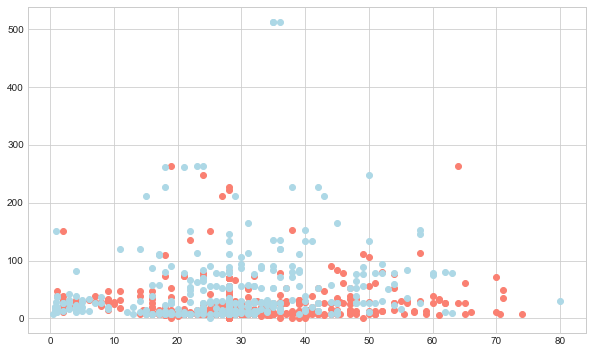

In [8]:
# Create another figure
plt.figure(figsize = (10,6))

# Scatter with positive examples
plt.scatter(df['Age'][df.Survived==0],
            df.Fare[df.Survived==0],
            c='salmon')
plt.scatter(df['Age'][df.Survived==1],
            df.Fare[df.Survived==1],
            c='lightblue')


In [ ]:
plt.figure(figs)

In [19]:
df.Age

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    28.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

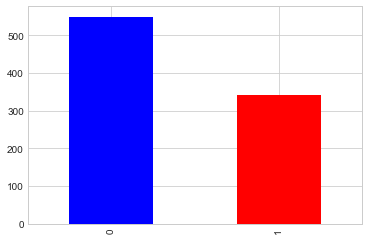

In [6]:
df['Survived'].value_counts().plot(kind='bar',color= ['blue','red']);

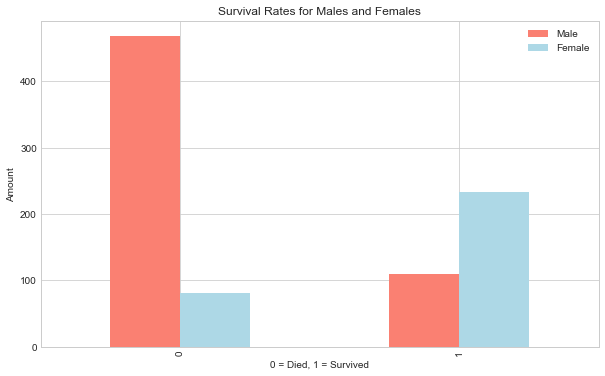

In [7]:
pd.crosstab(df['Survived'],df['Sex']).plot(kind='bar',
                                          figsize=(10,6),
                                          color = ['salmon','lightblue'])
plt.title('Survival Rates for Males and Females')
plt.xlabel('0 = Died, 1 = Survived')
plt.ylabel('Amount')
plt.legend(['Male','Female']);

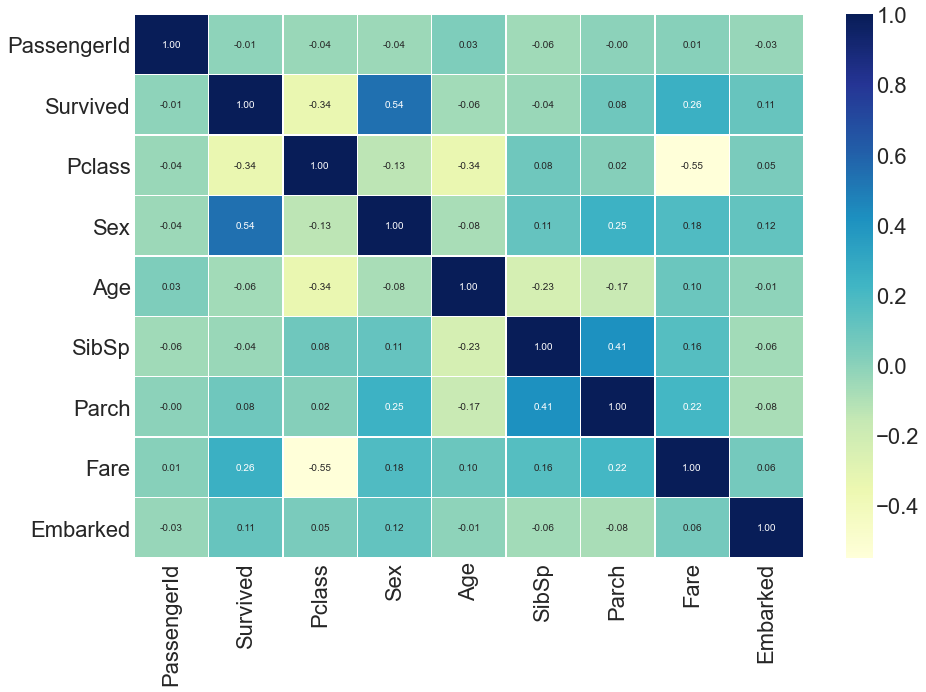

In [56]:
# It looks like the Majority of men perished while a majority of women survived
# Now lets make a correlation matrix
corr_matrix = df.corr()
fig,ax = plt.subplots(figsize=(15,10))
ax = seaborn.heatmap(corr_matrix,
                 annot=True,
                 linewidths = .5,
                 fmt ='.2f',
                 cmap='YlGnBu');

It looks like on the correlation matrix the most important metrics of survival are: 
1. Passenger Sex
2. Passenger Class
3. Passenger Fare

In [77]:
# To prevent overfitting, lets start with a reduced size model with just a few features
rdf = df.drop(['Fare','Embarked'],axis=1)

X = rdf.drop('Survived', axis=1)
y = rdf['Survived']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

In [78]:
model_dictionary = {
        'Random Forest' : RandomForestClassifier(),
        'Logistic Regression' : LogisticRegression(max_iter=750),
        'Extreme Gradient' : xgb.XGBClassifier(),
        'Kneighbors': KNeighborsClassifier(n_neighbors = 10),
        'CatBoost' : CatBoostClassifier(iterations=2,
                                        learning_rate=1,
                                        depth=2)}

# Lets Build some base level models too see which classifiers are preforming the best
def model_loop(models,X_train,X_test,y_train,y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train,y_train)
        model_scores[name] = model.score(X_test,y_test)
    return model_scores

In [79]:
model_loop(model_dictionary,X_train,X_test,y_train,y_test)

0:	learn: 0.5155283	total: 1.06ms	remaining: 1.06ms
1:	learn: 0.4695209	total: 1.68ms	remaining: 0us


{'Random Forest': 0.8324022346368715,
 'Logistic Regression': 0.8100558659217877,
 'Extreme Gradient': 0.8100558659217877,
 'Kneighbors': 0.5586592178770949,
 'CatBoost': 0.7932960893854749}

After messing around with the features a bit it appears that the optimal feature list for highest test accuracy is
1. Passenger ID
2. Passenger Age
3. Passenger Sex
4. Passenger Class
Now that we know this lets move on to adjusting hyperparameters for the the following models:
1. Random Forest Classifier


In [80]:
cat = CatBoostClassifier(iterations=2,learning_rate=1,depth=2)
cat.fit(X_train,y_train)
cat.score(X_test,y_test)

0:	learn: 0.5155283	total: 965us	remaining: 965us
1:	learn: 0.4695209	total: 1.81ms	remaining: 0us


0.7932960893854749

In [81]:
y_preds = cat.predict(X_test)

In [82]:
# Confusion matrix
cf_matrix = confusion_matrix(y_test,y_preds)
cf_matrix

array([[94, 17],
       [20, 48]], dtype=int64)

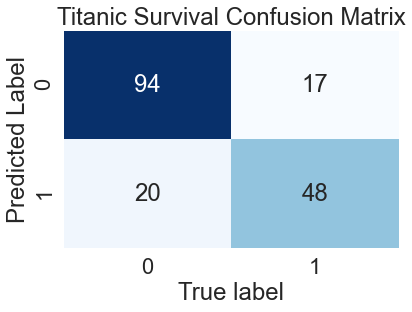

In [83]:
seaborn.set(font_scale=2)
seaborn.heatmap(cf_matrix, annot=True,cmap='Blues', cbar=False)
plt.title('Titanic Survival Confusion Matrix')
plt.xlabel('True label')
plt.ylabel('Predicted Label');

It looks like, at least for the base model, the most important aspect of survival is the passengers Sex, not the Class discrepency (This is what we found in our correlation matrix). But lets see if adjusting the hyperparameters will change anything

# Adjusting Hyperparameters for Multiple Models

We will take the following approach for ajusting hyperparameters:
1. Linear Regression - GridSearchCV
2. RandomForestClassification - RandomizedSearchCV
3. XGBoost - Baysian Model Optimization
4. Catboost - Baysian Model Optimization
5. Support Vector

In [84]:
## Support Vector
# svc_grid = {
#     'C': [0.1, 1, 10, 100, 1000],
#     'gamma':[0.1, 1, 10, 100],
#     'degree': [0, 1, 2, 3, 4, 5, 6],
#     'kernel':['linear', 'poly', 'rbf'],
# }

# rs_svc = RandomizedSearchCV(SVC(),
#                             param_distributions = svc_grid,
#                             cv = 5,
#                             n_iter = 10,
#                             verbose = True)
# rs_svc.fit(X_train,y_train)
# print(rs_svc.best_params_)
# print(rs_svc.score(X_test,y_test))

In [85]:
# logistic Regression
lr_grid = {
    'solver' : ['newton-cg','lbfgs','liblinear','sag','saga'],
    'penalty' : ['none','l1','l2','elasticnet'],
    'C' : [100,10,1.0,.1,.001]
}
np.random.seed(42)

rs_lr = RandomizedSearchCV(LogisticRegression(max_iter=750),
                           param_distributions = lr_grid,
                           cv = 5,
                           n_iter = 10,
                           verbose=False)
rs_lr.fit(X_train,y_train)
print(rs_lr.best_params_)
print(rs_lr.score(X_test,y_test))

C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sklearn\linear_m

C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sk

{'solver': 'newton-cg', 'penalty': 'none', 'C': 0.001}
0.8100558659217877


C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


In [86]:
# RandomForestClassification
rfc_grid = {'n_estimators':np.arange(10,250,50),
           'max_depth': [None,3,5,10],
           'min_samples_split':np.arange(2,20,2),
           'min_samples_leaf': np.arange(1,20,2)}

np.random.seed(42)
gs_rfc = RandomizedSearchCV(RandomForestClassifier(),
                          param_distributions=rfc_grid,
                          cv=5,
                          n_iter = 10,
                          verbose=False)
gs_rfc.fit(X_train,y_train)
print(gs_rfc.best_params_)
print(rs_lr.score(X_test,y_test))

{'n_estimators': 210, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_depth': 10}
0.8100558659217877


In [87]:
# CatBoost Parameters
cb_grid = {
    'learning_rate' : np.arange(0.05,0.31,.05),
    'max_depth' : np.arange(5,16,1),
    'iterations': np.arange(1,10,2)
}

np.random.seed(42)
rs_cb = RandomizedSearchCV(CatBoostClassifier(),
                           param_distributions = cb_grid,
                           cv=5,
                           n_iter = 10,
                           verbose=False)

rs_cb.fit(X_train,y_train)
print(rs_cb.best_params_)
print(rs_lr.score(X_test,y_test))

0:	learn: 0.6770652	total: 4.15ms	remaining: 0us
0:	learn: 0.6759767	total: 3.48ms	remaining: 0us
0:	learn: 0.6766903	total: 2.17ms	remaining: 0us
0:	learn: 0.6752334	total: 3ms	remaining: 0us
0:	learn: 0.6761389	total: 2.08ms	remaining: 0us
0:	learn: 0.6469111	total: 3.82ms	remaining: 15.3ms
1:	learn: 0.6067903	total: 5.05ms	remaining: 7.58ms
2:	learn: 0.5853531	total: 28.8ms	remaining: 19.2ms
3:	learn: 0.5590281	total: 30.4ms	remaining: 7.59ms
4:	learn: 0.5351509	total: 32.5ms	remaining: 0us
0:	learn: 0.6438577	total: 1.98ms	remaining: 7.91ms
1:	learn: 0.6015338	total: 2.65ms	remaining: 3.97ms
2:	learn: 0.5682321	total: 4.55ms	remaining: 3.04ms
3:	learn: 0.5443847	total: 8.16ms	remaining: 2.04ms
4:	learn: 0.5248731	total: 20.5ms	remaining: 0us
0:	learn: 0.6458522	total: 2.03ms	remaining: 8.11ms
1:	learn: 0.6052852	total: 2.83ms	remaining: 4.24ms
2:	learn: 0.5721028	total: 4.77ms	remaining: 3.18ms
3:	learn: 0.5495988	total: 8.49ms	remaining: 2.12ms
4:	learn: 0.5332674	total: 20.8ms	re

8:	learn: 0.4311895	total: 116ms	remaining: 0us
0:	learn: 0.6177602	total: 3.31ms	remaining: 26.5ms
1:	learn: 0.5637383	total: 4.15ms	remaining: 14.5ms
2:	learn: 0.5241962	total: 6.15ms	remaining: 12.3ms
3:	learn: 0.5028038	total: 9.86ms	remaining: 12.3ms
4:	learn: 0.4858854	total: 22.4ms	remaining: 17.9ms
5:	learn: 0.4762596	total: 23ms	remaining: 11.5ms
6:	learn: 0.4610643	total: 25ms	remaining: 7.15ms
7:	learn: 0.4524828	total: 37.3ms	remaining: 4.67ms
8:	learn: 0.4460166	total: 40.9ms	remaining: 0us
0:	learn: 0.6112774	total: 1.95ms	remaining: 15.6ms
1:	learn: 0.5529859	total: 3.04ms	remaining: 10.6ms
2:	learn: 0.5129156	total: 5.25ms	remaining: 10.5ms
3:	learn: 0.4855026	total: 8.99ms	remaining: 11.2ms
4:	learn: 0.4658632	total: 21.7ms	remaining: 17.3ms
5:	learn: 0.4552227	total: 22.3ms	remaining: 11.1ms
6:	learn: 0.4422527	total: 23.5ms	remaining: 6.73ms
7:	learn: 0.4310617	total: 27.2ms	remaining: 3.4ms
8:	learn: 0.4214334	total: 118ms	remaining: 0us
0:	learn: 0.6154022	total: 1

In [88]:
# XGBoost Parameters
xg_grid = {
    'learning_rate': np.arange(0.05, 0.31, 0.05),
    'max_depth': np.arange(5, 16, 1),
    'min_child_weight': np.arange(1, 8, 1),
    'subsample':('subsample', 0.8, 1),
}

np.random.seed(42)
rs_xg = RandomizedSearchCV(xgb.XGBClassifier(),
                            param_distributions = xg_grid,
                            cv = 5,
                            n_iter = 10,
                            verbose = False)

rs_xg.fit(X_train,y_train)
print(rs_xg.best_params_)
print(rs_xg.score(X_test,y_test))

C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\xgboost\sklearn.py", line 824, in fit
    callbacks=callbacks)
  File "C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\xgboost\training.py", line 212, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\xgboost\training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "C:\Users\Ethan\Desktop\data_science\env\lib\site-packages\xgboost\core.py", line 1369, in update
    dtrain.han

{'subsample': 0.8, 'min_child_weight': 6, 'max_depth': 10, 'learning_rate': 0.05}
0.8379888268156425


It looks like I have similar accuracies for all of my models after hyperparameter tuning which appears to be the direct result of Sex being such an important variable, because it is such an important value for survival most of my models are just assuming the majority of men die and majority of women live, which gives us about an 80% accuracy rate simply by guessing that.

At First I removed all variables besides sex, age and passenger class, then I reran all the models with sibch and parch which gave me a finalized model accuracy of 84%, Which I will use on the test data and upload to Kaggle (along with testing whether or not any of my friends/family members would have made it :D)

In [90]:
# Let's save the model for future use
import pickle
pickle.dump(rs_xg, open('titanic_model.sav', 'wb'))

In [122]:
test_df = pd.read_csv('test.csv')
test_df = clean_dataframe(test_df)
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,2
1,893,3,1,47.0,1,0,7.0000,0
2,894,2,0,62.0,0,0,9.6875,2
3,895,3,0,27.0,0,0,8.6625,0
4,896,3,1,22.0,1,1,12.2875,0


In [123]:
# Get the same data for the other one
rdf = test_df.drop(['Fare','Embarked'],axis=1)

In [124]:
preds = rs_xg.predict(rdf)

In [125]:
print(preds)

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [126]:
test_df['Survived'] = preds

In [127]:
survived = pd.Series(preds)

In [131]:
final = test_df.drop(columns=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'])

In [135]:
final.to_csv('submission.csv',index=False)

In [136]:
test_df['Sex'].value_counts()

0    266
1    152
Name: Sex, dtype: int64

In [137]:
final['Survived'].value_counts()

0    292
1    126
Name: Survived, dtype: int64

My model is doing more than simply assuming all men will die and all women survive which is good.
After submitting my final project to Kaggle it scored it at 77.5% accurate, which is pretty good for a first attempt, though it doesn't quite achieve the 80% which I set for my goal.

Now let's continue with a new file to see who makes it out of my friends and family

In [147]:
fdf = pd.read_csv('friends.csv')
fdf.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch
0,892,3,Ethan Chavez,0,25.7,3,2


In [139]:
test = fdf.drop(columns=['Name'])

In [140]:
predictions = preds = rs_xg.predict(test)
predictions

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0], dtype=int64)

In [141]:
fdf['Survived'] = predictions

In [145]:
fdf.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Survived
0,892,3,Ethan Chavez,0,25.7,3,2,0


In [143]:
fdf.to_csv('friends_survived.csv',index=False)

# Oh dear it appears I have died